In [32]:
import numpy as np
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

## Single Example

In [39]:
N = 20
M = 50
sigma = 0.1                 # Corresponding to 20dB

# Generate fixed H (measurement matrix)
H = np.random.normal(0, 1, size=(N, M))

# Generate a single sparse x
x_true = np.zeros(M)
non_zero_indices = np.random.choice(M, size=M//10, replace=False)
x_true[non_zero_indices] = np.random.normal(0, 1, size=M//10)

# Generate observed Y with Gaussian noise
noise = np.random.normal(0, sigma, N)
Y = H @ x_true + noise  # Single observed data point

stan_data = {
    "N": N,
    "M": M,
    "Y": Y,
    "H": H,
    "sigma": sigma,
}


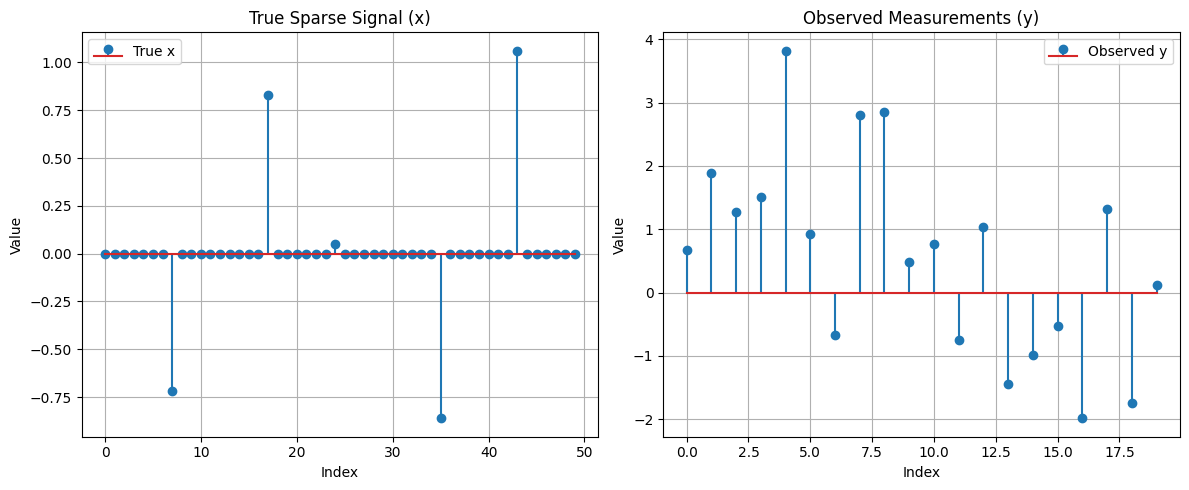

In [40]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Plot x_true
plt.subplot(1, 2, 1)
plt.stem(range(M), x_true, label='True x')
plt.title('True Sparse Signal (x)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Plot y
plt.subplot(1, 2, 2)
plt.stem(range(N), Y, label='Observed y')
plt.title('Observed Measurements (y)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [41]:

model = CmdStanModel(stan_file="latent.stan")
fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)

posterior_samples = fit.draws_pd()
mean_x = np.array((posterior_samples.filter(like='x').mean()))
std_x = np.array((posterior_samples.filter(like='x').std()))

19:41:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:04 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:04 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:05 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:05 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:05 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:05 Iteration:  800 / 2000 [ 40%]  (Warmup)

chain 1 |█████▍    | 00:05 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |██████▎   | 00:05 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:05 Iteration: 1300 / 2000 [ 65%]  (Sampling)
chain 1 |████████▏ | 00:06 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:06 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 1 |██████████| 00:06 Iteration: 1900 / 2000 [ 95%]  (Sampling)





chain 1 |██████████| 00:06 Sampling completed                       
cha


19:41:43 - cmdstanpy - INFO - CmdStan done processing.
19:41:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 19 divergent transitions (1.9%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


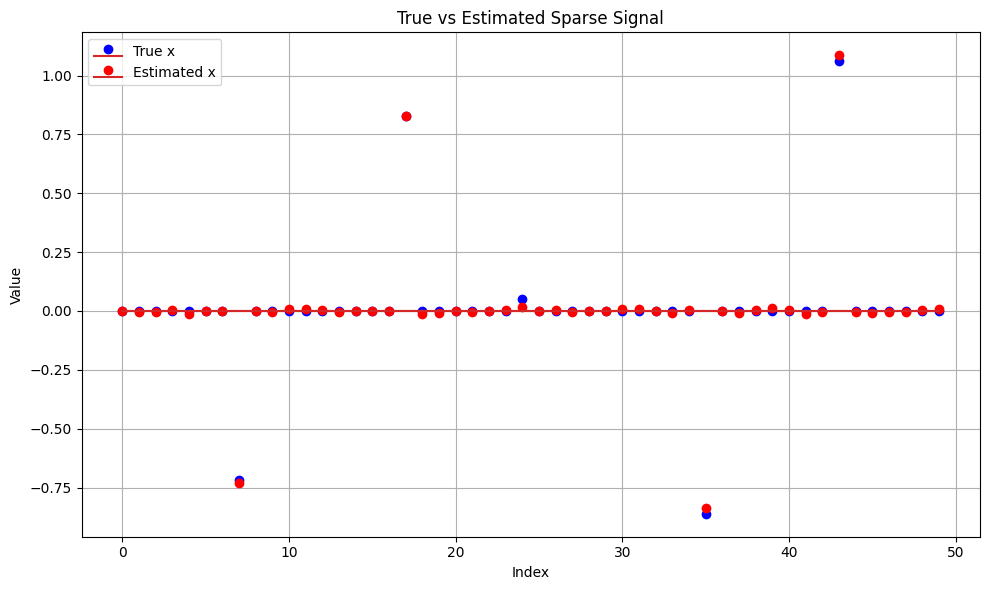

In [44]:
# Create a figure
plt.figure(figsize=(10, 6))

# Plot true x values (use 'None' for linefmt to remove vertical lines)
plt.stem(range(M), x_true, label='True x', linefmt='None', markerfmt='bo')

# Plot estimated x values (use 'None' for linefmt to remove vertical lines)
plt.stem(range(M), mean_x, label='Estimated x', linefmt='None', markerfmt='ro')

plt.title('True vs Estimated Sparse Signal')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
norm_diff_squared = np.sum((x_true - mean_x)**2)
norm_x_squared = np.sum(x_true**2)
NMSE = norm_diff_squared / norm_x_squared

NMSE

0.0013827821513176669

## Generalized

In [48]:
snr_ranges = list(range(0,31,5))

sigma_list = []

for snr in snr_ranges:
    sigma_sq = 10**(-snr/10)
    sigma = sigma_sq**0.5
    sigma_list.append(sigma)

sigma_list

[1.0,
 0.5623413251903491,
 0.31622776601683794,
 0.17782794100389226,
 0.1,
 0.05623413251903491,
 0.03162277660168379]

In [49]:
def get_nmse(N, M, sigma):
    
    # Generate fixed H (measurement matrix)
    H = np.random.normal(0, 1, size=(N, M))

    # Generate a single sparse x
    x_true = np.zeros(M)
    non_zero_indices = np.random.choice(M, size=M//10, replace=False)
    x_true[non_zero_indices] = np.random.normal(0, 1, size=M//10)

    # Generate observed Y with Gaussian noise
    noise = np.random.normal(0, sigma, N)
    Y = H @ x_true + noise  # Single observed data point

    stan_data = {
        "N": N,
        "M": M,
        "Y": Y,
        "H": H,
        "sigma": sigma,
    }

    model = CmdStanModel(stan_file="latent.stan")
    fit = model.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=1000, max_treedepth=15)

    posterior_samples = fit.draws_pd()
    mean_x = np.array((posterior_samples.filter(like='x').mean()))
    std_x = np.array((posterior_samples.filter(like='x').std()))

    norm_diff_squared = np.sum((x_true - mean_x)**2)
    norm_x_squared = np.sum(x_true**2)
    NMSE = norm_diff_squared / norm_x_squared


    return NMSE
    


In [50]:
NMSE_mean_dict = {}
NMSE_stdev_dict = {}

for i in range(len(snr_ranges)):
    
    nmse_total = 0
    K = 1                               # The no. of iterations u want to run for!
    nmse_values = []
    for iter in range(K):
        nmse_values.append(get_nmse(N=20, M=50, sigma=sigma_list[i]))
    NMSE_mean_dict[snr_ranges[i]] = np.mean(nmse_values)
    NMSE_stdev_dict[snr_ranges[i]] = np.std(nmse_values)


19:44:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:04 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:06 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:07 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)
chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:10 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)
chain 1 |█████▉    | 00:11 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▊   | 00:12 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |███████▎  | 00:13 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |


19:44:51 - cmdstanpy - INFO - CmdStan done processing.
19:44:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 165 divergent transitions (16.5%)
	Chain 2 had 111 divergent transitions (11.1%)
	Chain 3 had 94 divergent transitions (9.4%)
	Chain 4 had 46 divergent transitions (4.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:44:52 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status







chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)







chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)



chain 1 |██▋       | 00:08 Iteration:  400 / 2000 [ 20%]  (Warmup)




chain 1 |███▏      | 00:08 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:08 Iteration:  600 / 2000 [ 30%]  (Warmup)




chain 1 |████      | 00:09 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:09 Iteration:  800 / 2000 [ 40%]  (Warmup)




chain 1 |█████     | 00:10 Iteration:  900 / 2000 [ 45%]  (Warmup)




chain 1 |█████▉    | 00:10 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:11 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████▊   | 00:11 Iteration: 1200 / 2000 [ 60%]  (Sampling)
chain 1 |███████▎  | 00:12 Iteration: 1300 


19:45:07 - cmdstanpy - INFO - CmdStan done processing.
19:45:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (2.0%)
	Chain 2 had 36 divergent transitions (3.6%)
	Chain 3 had 37 divergent transitions (3.7%)
	Chain 4 had 243 divergent transitions (24.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:45:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:04 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▎       | 00:04 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:05 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 1 |███▏      | 00:05 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:05 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:05 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:06 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:06 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:06 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:07 Iteration: 1200 / 2000 [ 60%]  (Sampling)





chain 1 |███████▎  | 00:07 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 00:07 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 1 |████████▏ | 00:07 Iteration: 1500 / 2000 [ 75%]  (Sa


19:45:18 - cmdstanpy - INFO - CmdStan done processing.
19:45:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 87 divergent transitions (8.7%)
	Chain 2 had 44 divergent transitions (4.4%)
	Chain 3 had 42 divergent transitions (4.2%)
	Chain 4 had 97 divergent transitions (9.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:45:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status



chain 1 |▉         | 00:04 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |█▎        | 00:04 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:05 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:05 Iteration:  300 / 2000 [ 15%]  (Warmup)

chain 1 |██▋       | 00:05 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |███▏      | 00:05 Iteration:  500 / 2000 [ 25%]  (Warmup)
chain 1 |███▋      | 00:05 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |████▌     | 00:06 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████     | 00:06 Iteration:  900 / 2000 [ 45%]  (Warmup)



chain 1 |█████▉    | 00:06 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)



chain 1 |███████▎  | 00:06 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |███████▋  | 00:07 Iteration: 1400 / 2000 [ 70%]  (Sampling)


c


19:45:27 - cmdstanpy - INFO - CmdStan done processing.
19:45:27 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


19:45:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:04 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |█▎        | 00:05 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |█▊        | 00:05 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:05 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:05 Iteration:  500 / 2000 [ 25%]  (Warmup)



chain 1 |████      | 00:05 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████     | 00:05 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |███████▎  | 00:06 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▏ | 00:06 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |█████████ | 00:06 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:06 Iteration: 1900 / 2000 [ 95%]  (Sampling)











chain 1 |██████████| 00:07 Sampling completed                   


19:45:35 - cmdstanpy - INFO - CmdStan done processing.
19:45:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 16 divergent transitions (1.6%)
	Chain 3 had 1 divergent transitions (0.1%)
	Chain 4 had 15 divergent transitions (1.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:45:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status












chain 1 |▉         | 00:05 Iteration:    1 / 2000 [  0%]  (Warmup)





chain 1 |█▎        | 00:05 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▎       | 00:05 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |███▏      | 00:05 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████     | 00:06 Iteration:  900 / 2000 [ 45%]  (Warmup)

chain 1 |██████▎   | 00:06 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |███████▎  | 00:06 Iteration: 1300 / 2000 [ 65%]  (Sampling)

chain 1 |████████▏ | 00:06 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                       
chain 2 |██████████| 00:07 Sampling completed                       
chain 3 |██████████| 00:07 Sampling completed                       
chain 4 |██████████| 00:07 Sampling completed                       


19:45:42 - cmdstanpy - INFO - CmdStan done processing.
19:45:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 18 divergent transitions (1.8%)
	Chain 4 had 11 divergent transitions (1.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
19:45:42 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

































chain 1 |▉         | 00:06 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |██████████| 00:08 Sampling completed                       
chain 2 |██████████| 00:08 Sampling completed                       
chain 3 |██████████| 00:08 Sampling completed                       
chain 4 |██████████| 00:08 Sampling completed                       


19:45:51 - cmdstanpy - INFO - CmdStan done processing.
19:45:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 35 divergent transitions (3.5%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 4 had 8 divergent transitions (0.8%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [51]:
NMSE_mean_dict, NMSE_stdev_dict


({0: 0.5770601646622895,
  5: 0.14677635420657648,
  10: 0.02506426256427091,
  15: 0.017160543134444605,
  20: 0.0018218689978933217,
  25: 0.00017342180145647382,
  30: 0.00034245785817577497},
 {0: 0.0, 5: 0.0, 10: 0.0, 15: 0.0, 20: 0.0, 25: 0.0, 30: 0.0})

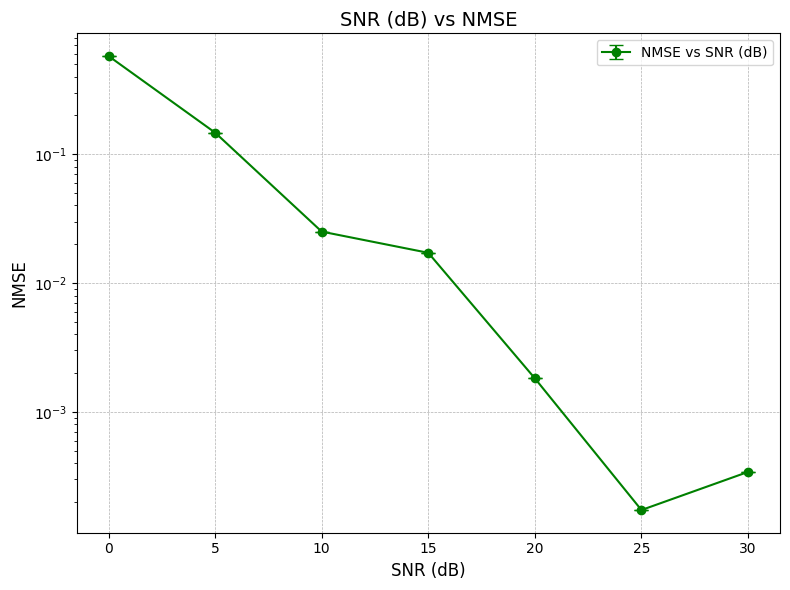

In [52]:
snr = list(NMSE_mean_dict.keys())
nmse_mean = list(NMSE_mean_dict.values())
nmse_stdev = list(NMSE_stdev_dict.values())

# Plotting
plt.figure(figsize=(8, 6))
plt.errorbar(snr, nmse_mean, yerr=nmse_stdev, marker='o', linestyle='-', color='g', 
            label='NMSE vs SNR (dB)', capsize=5)
plt.xlabel('SNR (dB)', fontsize=12)
plt.ylabel('NMSE', fontsize=12)
plt.title('SNR (dB) vs NMSE', fontsize=14)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()